# Interpretation of Shapley values

In this chapter you'll learn:

- correct interpretation of Shapley values
  - for linear models
  - for additive models
  - with interactions (like most models have in ML)
- pitfalls for interpretation
- interpretation for many special cases
-


TODO: Look at examples here: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression


## Shapley values for linear models

In [452]:
import shap
from sklearn.linear_model import LinearRegression
X,y = shap.datasets.california(n_points=3000)
background = shap.utils.sample(X, 2000)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Alright, now we have a linear regression model.
Let's first inspect the coefficients and then compare it with the corresponding Shapley values.

In [453]:
import pandas as pd
coefs = pd.DataFrame({"feature": X.columns.values, "value": model.coef_})
print(coefs)

      feature     value
0      MedInc  0.457325
1    HouseAge  0.009440
2    AveRooms -0.140501
3   AveBedrms  1.105387
4  Population  0.000005
5    AveOccup -0.003361
6    Latitude -0.418640
7   Longitude -0.437567


In [454]:
explainer = shap.Explainer(model.predict, background)
shap_values = explainer(X)

Exact explainer: 3001it [00:11, 20.79it/s]                                                   


Alright, now let's plot the feature "MedInc" against its shapley values.

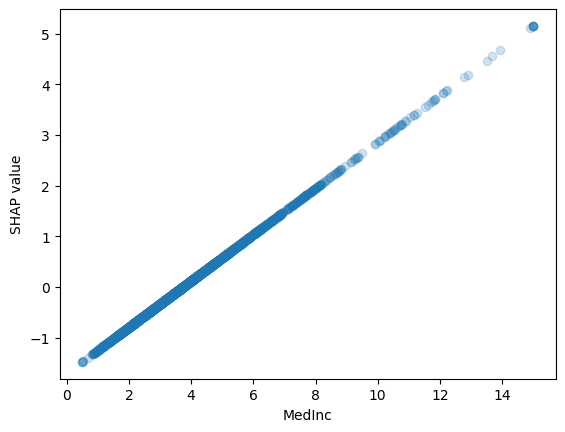

In [455]:
import matplotlib.pyplot as plt
# select one feature for plotting SHAP values
feature_name = 'MedInc'
feature_idx = X.columns.get_loc(feature_name)

# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values.values[:, feature_idx], alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')
plt.show()

So we can see that the Shapley value increases linearly with each increase in the feature. And this increase is exactly the same as the slope in 

In [456]:
coefs.value[feature_idx]

0.45732460121985236

In [457]:
model.intercept_

-37.81505214409206

We know that in linear regression models, $\phi_{ji}(\hat{f}) = \beta_j x_j - E(\beta_jX_j) = \beta_j (x_j - E(X_j))$
Let's confirm that this is correct:

In [458]:
X[feature_name].mean()

3.8714374666666664

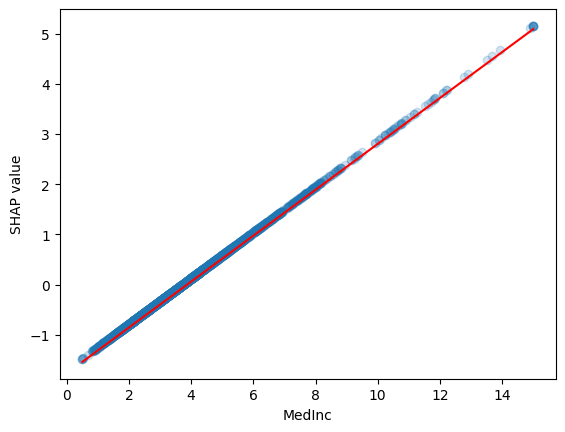

In [459]:
import numpy as np
# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values.values[:, feature_idx], alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')

x_range = np.array([X[feature_name].min(), X[feature_name].max()])

plt.plot(x_range, coefs.value[feature_idx] * (x_range - X[feature_name].mean()), color='red')

plt.show()

Looking good, and within an estimation error.

This gives us a first amount of trust in the method.

So we know that when

- the model is additive
- the effects are linear

then the Shapley values are the model coefficient multiplied with the actual feature value minus some constant.
This product is also called the feature effect for an instance.
Because the coefficient alone couldn't tell us how important a feature was for a particular instance. Because it also depends on the actual feature value: if it is large, in absolute terms, then the contribution to the outcome will be much larger than when the value is near zero.
The constant simply adjusts the values towards the mean effect, so that the plot is centered around the *expected feature effect*.

## Shapley values for additive models

In this next step, we allow the relation between a feature and the target to be non-linear.
We don't, however, allow interactions between the features.
Additive models with non-linear base functions are perfectly modeled with so-called generalized additive models, also called GAMs.


A GAM models y in the following way:

$$\hat{f}(x) = \beta_0 + \beta_1 f_1(x_1) + \ldots + f_p(x_p)$$

The difference to the simple linear model is that we allow the functions $f_j$. If these are the identity function for all features, namely $f_j(x_j) = x_j$, then we again come out with the linear model.
So linear regression models are special cases of GAMs.

But with GAMs, we can now have arbitrary functions for the features.
A popular choice are spline functions which allow for rather flexible shapes of functions that are still smooth and have a gradient.

Educationally, to understand Shapley values, they are perfect, because they allow us to study what happens with non-linear functions, but without interactions.
Because only with interactions will the interpretation become trickier.

So we go back to the same example and fit a GAM instead of a linear regression model.

For this we rely on the interpret Python library. YOu can install it with:

In [460]:
!pip install interpret

Then we train the model:

TODO: Rewrite that code

First we fit a model.
It's an explainable boosting regressor from the interpet package

::: .{callout-note}

From the docs: https://interpret.ml/docs/ebm.html

Explainable Boosting Machine (EBM) is a tree-based, cyclic gradient boosting Generalized Additive Model with automatic interaction detection. EBMs are often as accurate as state-of-the-art blackbox models while remaining completely interpretable. Although EBMs are often slower to train than other modern algorithms, EBMs are extremely compact and fast at prediction time.

TODO: Turn into quote, or say in own words

:::

In [461]:
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

ExplainableBoostingRegressor(interactions=0)

Next, we produce the Shapley values values

In [462]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, background)
shap_values_ebm = explainer_ebm(X)

The question now: How do the Shapley values look like?
And does it match what we would expect?

But first we have to define what we expect.
Since the model is a GAM (TODO: check out ExplainableBoostingRegressor and add details here), we know what the dependence of the target on a feature look like.

We can simply visualize this with the following code:


In [463]:
model_ebm.explain_global?

In [464]:
from interpret import show
ebm_global = model_ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/11428576080/ -->

Text(0, 0.5, 'SHAP value')

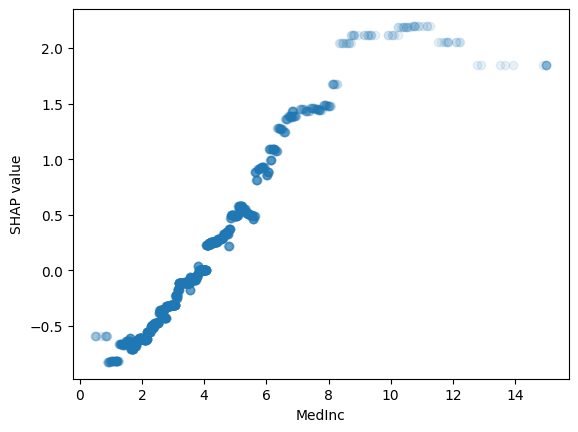

In [465]:
# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values_ebm.values[:, feature_idx], alpha=0.1)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')

In [466]:
X.iloc[0]

MedInc           1.388200
HouseAge        15.000000
AveRooms         3.929530
AveBedrms        1.100671
Population    1024.000000
AveOccup         3.436242
Latitude        32.800000
Longitude     -115.560000
Name: 2732, dtype: float64

In [467]:
X.iloc[0]

MedInc           1.388200
HouseAge        15.000000
AveRooms         3.929530
AveBedrms        1.100671
Population    1024.000000
AveOccup         3.436242
Latitude        32.800000
Longitude     -115.560000
Name: 2732, dtype: float64

In [468]:
first_row = X.iloc[np.repeat(0, 100)]
# create the MedInc column with values ranging from min(MedInc) to max(MedInc) on an equidistant grid
MedIncRange = np.linspace(X['MedInc'].min(), X['MedInc'].max(), num=100)
first_row['MedInc'] = MedIncRange
# print the new DataFrame
print(first_row)

         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
2732   0.499900      15.0   3.92953   1.100671      1024.0  3.436242   
2732   0.646367      15.0   3.92953   1.100671      1024.0  3.436242   
2732   0.792833      15.0   3.92953   1.100671      1024.0  3.436242   
2732   0.939300      15.0   3.92953   1.100671      1024.0  3.436242   
2732   1.085767      15.0   3.92953   1.100671      1024.0  3.436242   
...         ...       ...       ...        ...         ...       ...   
2732  14.414233      15.0   3.92953   1.100671      1024.0  3.436242   
2732  14.560700      15.0   3.92953   1.100671      1024.0  3.436242   
2732  14.707167      15.0   3.92953   1.100671      1024.0  3.436242   
2732  14.853633      15.0   3.92953   1.100671      1024.0  3.436242   
2732  15.000100      15.0   3.92953   1.100671      1024.0  3.436242   

      Latitude  Longitude  
2732      32.8    -115.56  
2732      32.8    -115.56  
2732      32.8    -115.56  
2732      32.8    -115.

/var/folders/5q/m5yfk63j7293f91h2f1zj8j00000gn/T/ipykernel_93534/3726400141.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [469]:
preds = model_ebm.predict(first_row)

TODO: Figure out how to compute the differences in intercept between PDP and SHAP here

In [470]:
correction_factor = 0.68

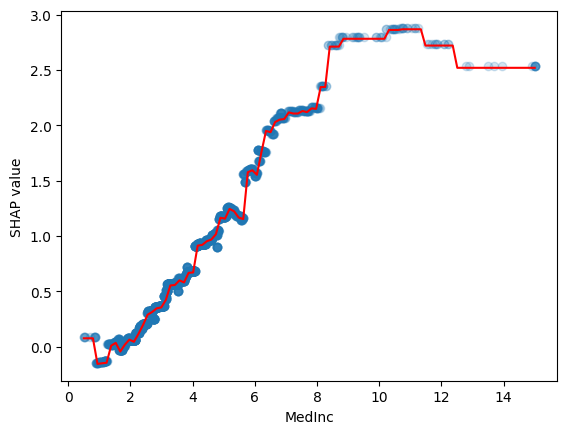

In [471]:
import numpy as np

Xpred = model_ebm.predict(X).mean()

# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values_ebm.values[:, feature_idx] + correction_factor, alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')


x0pred = model_ebm.predict(X.iloc[[0]])

plt.plot(MedIncRange, preds - x0pred, color='red')

plt.show()

Again, as you can see, the SHAP values follow the same trajectory as when we would simply change one of the features (here MedInc).
This gives us another boost in the trust of understanding Shapley values.

But things get tricky when we have interactions.

And they get really tricky when we have interactions + correlations.
But manageable (and other interpretation methods have to deal with the same difficulties)

## Shapley values and feature interactions

Goal in this section: Show how Shaplye values are to be interpreted when two features interact.

::: {.callout-note}

## Feature Interaction

Two features interact when the prediction can't be explained by the sum of the feature effects.

:::

A simple example of a model with interactions:

$$f(x) = x_1 + x_2 + x_1 * x_2$$

We can't explain the prediction as a sum of only to feature effects, because we have this term here where both features are "entangled".

What does this mean for shapley values?

Let's go back to the fundamentals:
Shapley values fairly attribute the prediction to the individual features.
Let's walk through the terms in the example above:
x_1 can be attributed to feature 1 of course, same for x_2 to feature 2.
And the effect of the product needs to be fairly split between the features.


Simulate the function f(x1,x2) = x1 + x2 + x1 * x2. Then fit a random forest with sklearn (Python), then explain the predictions with shapley values

First, we need to import the necessary libraries for this task. We will use numpy for numerical computations, pandas for data manipulation, and sklearn for machine learning tasks.


/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



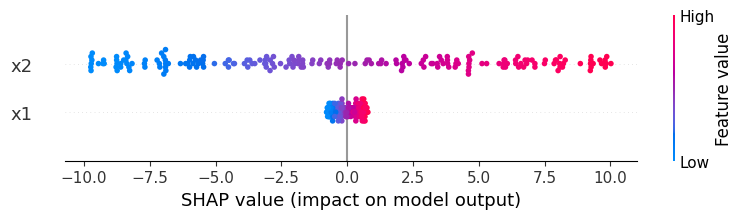

In [472]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

n = 1000

# Create a new dataframe with two columns, x1 and x2
df = pd.DataFrame({'x1': np.random.uniform(-1, 1, n),
                   'x2': np.random.uniform(-10, 10, n)})

# Compute the target variable y
df['y'] = df.x1 + df.x2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

Again, but this time adding the interation

/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



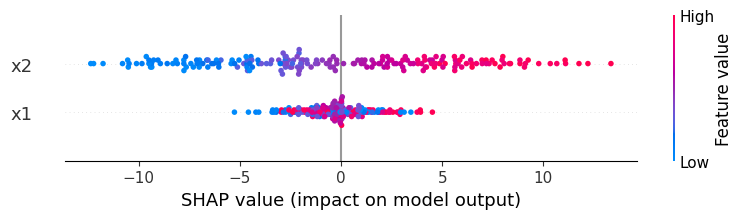

In [473]:
# Compute the target variable y
df['y'] = df.x1 + df.x2 + df.x1 * df.x2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

Second example with interactions. This time only interactions, no 

/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



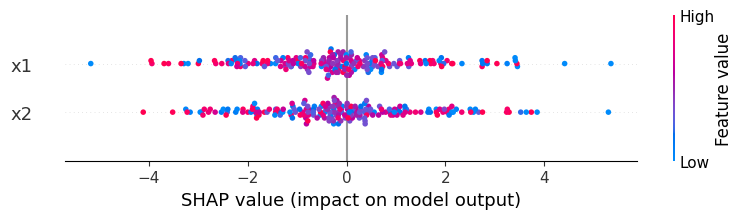

In [474]:
# Compute the target variable y
df['y'] = df.x1 * df.x2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

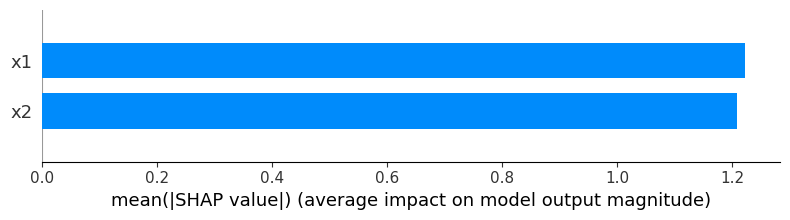

In [475]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The features have the same feature importance!

How can that be?
X1 has a so much bigger range, but otherwise both features have the same role and shape.
Shouldn't X1 be more important?

Let's Play a game. I'll give you a value of X1, and you tell me what information this gives you about the outcome.

What can well say when X2 = 0?

Answer: f(X1, 0) = 0 * X1 = 0. So we know it's always zero.

What can we say when X2 = 9?

Answer: Since X1 can be between -1 and 1, we know that f(x) will be in the range of -9 to 9.

So there is value in knowing X2.

Let's do the same for X1:

If X1 is zero, f(0, X2) = 0 as well.

If X1 is 0.9, we know that $f(0.9, X2) = 0.9 * X2 \in [-9,9]$ because $X_1 \in [-10, 10]$

So we had symmetrical outputs, and even though X2 is on a larger scale, knowing either X1 or X2 gives us the same amount of inferomation.

Whether you like that interpretation or not, that's how Shapley values work for interactions, at least in the case of mulitplication.


In [476]:
# Compute the target variable y
df['y'] = ((df.x1 >= -5) | (df.x2 >= -.5)) * (df.x1 + df.x2) + 20 * (df.x1 < -.5) * (df.x2 < -5)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

That's what the function looks like

/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



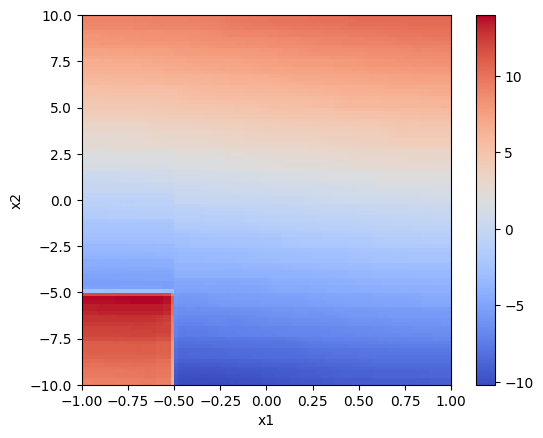

In [477]:
# Generate x1 and x2 grids
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-10, 10, 100)
xx1, xx2 = np.meshgrid(x1, x2)

# Flatten the grids and predict color
X = np.column_stack((xx1.ravel(), xx2.ravel()))
color = rf_model.predict(X)

# Reshape the predicted color array
color = color.reshape(xx1.shape)

# Plot the heatmap
plt.imshow(color, extent=[x1.min(), x1.max(), x2.min(), x2.max()],
           origin='lower', cmap='coolwarm', aspect = 0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()


/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



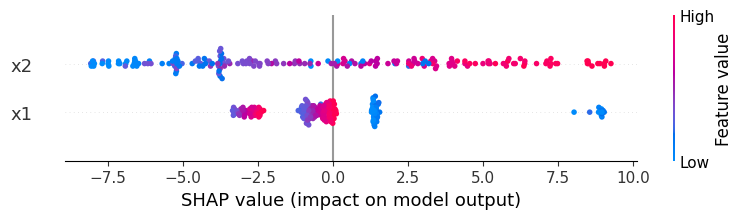

In [478]:
# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

This needs a deeper investigation to  understand what's going on.

Let's have a look at the dependence plot of x1.
The dependence plot shows how the SHAP values depends on the feautre, in our case X1.

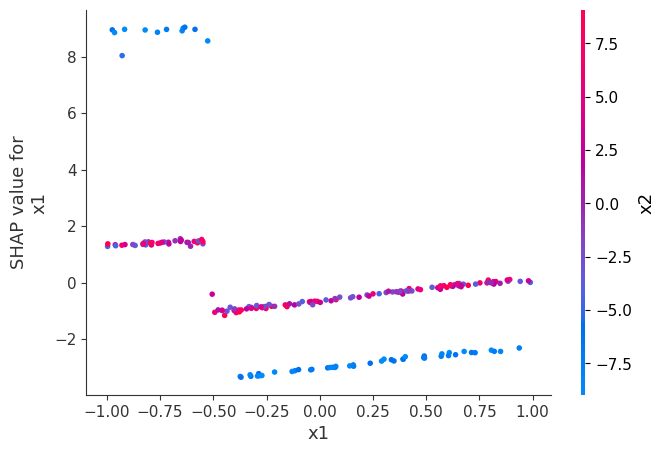

In [479]:
shap.dependence_plot("x1", shap_values, X_test)

The dependence plot does something very interesting automatically.
It detects interaction with other features. Since we only have x2 as other feature, it shows interactions with x2.
These are indiciated by the color.

But first lets' see what's going on.
3 observations:

1. Somethings happens at 0.5: a large jump down in prediction
1. Ignoring the jump, there seems to be a linear upwards trend
1. There are two "clusters" of points: one with the small jump, and one with the large jump

Part 3 becomes clearer because the curves are colored by the feature value X2.

Let's explain all these occurences:

- The linear trend is in line with the coefficient of the way we simulated the data
- the jump at -0.5 makes also sense
- it also makes sense that we see two curves:
  - one curve is for values of x2 below -5
  - the other curve is for values of x2 above -5

It makes sense to see this huge jump for X2<-5 cluster, because in this case the value of X1 decides whether or not the data point lies in the special rectangle, increasing the predictions by a lot.

But the big question that remains: Why do we also see the jump when $X_2 > -5$???

For that we have to go back to the basics of Shapley values.
The Shapley value for X1 is the marginal contribution of adding X1 to a coalition.
IN our case that can be a coalition that is empty or a coalition where X2 is already present.

Keep in mind that we are at the moment having under the microscope the Shapley values for a subset of the data where $X_2 > -5$.

So when we compute the Shapely value for $X_1$, then it's a mix of two coalitions:

1. adding to $\emptyset$: For this case we sample $X_2$ and also $(X_1, X_2)$
1. adding to $X_2$: For this case we sample $X_2$ and for the full coaliation we don't sample anything

We can actually calculate the Shapley value as:

$$\phi_1 = ...$$


In the first case, where we start with an emtpy coalition and sample both $X_1$ and $X_2$, we also sometimes sample from the special rectangle.
And then it makes a difference whether the value of $X_1$ for the current instances for which we compute Shapley values is below -0.5 or not.
That's why we see the jump as well for this subset when $X_5 > -5$.

Tricky, right?

Where does that leave us when we apply Shapley values for model interpretation?
Let's break it down:

- A data point that has $(X_1 = -0.6, X_2 = +8)$ and will get a Shapley value $\phi_1 \approx 1$
- A data point that has $(X_1 = -0.4, X_2 = +8)$ and will get a Shapley value $\phi_1 \approx -1.5$

You could make the argument that both of the above data points should get almost the same Shapley value and if anything data point 2 should get the larger Shapley value. Because increasing $X_1$ increases the prediction.
But instead we see a jump down.

Comparing these two data points, only X_1 changed.
Since we know f(x), we know that in between no jump happens because X_2 is too large for that and we are not in the special rectangle area.

In [480]:
Xnew = pd.DataFrame({"X1": [-0.6, -0.4], "X2": [8,8]})
shap_values = explainer.shap_values(Xnew)
print(rf_model.predict(Xnew.values))
print(shap_values)

[7.46733694 7.66497012]
[[ 1.46883832  4.75619904]
 [-1.00365578  7.42632632]]


/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



So the predictions are almost the same.
But for one case the Shapley values are both positive.
For the second case the X1 Shapley value is negative and on the other hand the X2 value more positive than for the other data point.

Let's look at the background data: It's uniform across -10,10 for X_2 and -1,1 for X_1
1/8th of the data is in the special rectangle with a very high predicted value. For the rest 7/8th of the data we have a simple linear predictor.

But if you think about it, it makes sense:

- Point 1 $(X_1=-0.6, X_2=8)$ this point already has "one foot" in the special rectangle. From that standpoint, what is the role of $X_1$? We have to think about the background data as well. For 1/4th of the background data, adding the player $X_1=-0.6$ would mean stepping fully into the rectangle and getting that juicy +20 in the prediction. And in that regard $X_1$ plays a positive role. In fact all data points with $X_1 < -0.5$ (including a buffer zone since the random forest does it a bit smoothly) have a postiive Shapley value $\phi_1$!
- Point 2 with $(X_1=-0.4, X_2=8)$, on the other hand has an $X_1$ value that is the worst of both worlds (if you see a low prediction as bad). It doesn't help **any** data point from the background data to enter the magical rectangle. But it's also on the lower end in terms of the linear factor. So it makes sense to get a negative value.

But what about the difference between the Shapley values $\phi_2$ for $X_2$?
We observe that both are positive, but the second is larger.
Makes sense that they are positive, because for all data points with $x_2 \in [-5, 7.99]$ which means an improvement for 60% of the data points, and adding to that all the ones X_2 < -5 but X1 > -0.5, which are 0.25 * 0.75 = 0.1875 another 18.75% and in total 78.75% of the data. Of course t's not the percentage that counts, but the expected value (value times probability) but that's to get a feel for it.
But why is $\phi_2$ larger for the second data point, even though $X_2=8$ for both instances?
Because adding $X_2=8$ to a data point with $X_1=-0.6$ then to a data point $X_1=-0.4$. Why?
IN both cases, adding to an empty coalition is the same.
But the difference is adding to the $X_1$, which differ between the two data points.
Adding to an $X_1=-0.6$ "robs" that data point of the chance of being placed in the special rectangle.
But adding it to $X_1=0.4$ is only positive.
Again look at the background data: ON AVERAGE, adding $X_2=8$ is worse if we already know that the data point is with one step in the special rectangle, because some of the background data would have made it into the rectangular. In comparison any coalition with $X_1=-0.4$ means no change of special rectangular time anyways.

This example with some real application:

$X_1$ = height, $X_2$ = how long you can stand on your toes. $f(x1, x2)$ is how much you can see from a concert while standing in the crowd. Of course, the taller you are and the better you can stand on your toes, the more you see of the band.
But for visitors that are small and can't stand on their toes, they are allowed to sit on the shoulders of tall people.
So that's a huge bonus in how much you can see (+20).


Now imagine someone who is just a little to tall for getting to stand on the "shoulders of giants". This person will look at the people essentially the same size, but just a tad smaller and enjoying the view.

Person 1: Small enough for shoulder position, but too good at standing on their toes
Person 2: Slightly too large for shoulders, and too good at standing on their toes

Person 1: positive shapley value for size, and mid strengthy shapley value for toe abilities
Person 2: negative shapley value for size, large shapley value for toes.

So it's not about regret and what-if analysis!

Person 1: has positive shapley value for size since many others of the same size could profit from shoulders. Also positive values for toes, because person quite skilled at standing on their toes. But ultimately this toe value prohibited this person also from getting should spot.

Person 2: has negatve value for tallness. Because this person can't see well with this size, and also doesn't benefit from shoulder bonus. Large value for toes, because this person benefits from toes. Doesn't get the "penalization" as person 1 were this toe-abilities prohibited the shoulder spot -- person was too tall for that anyways. 



This hones down an important lesson:

**Shapley values are not counterfactuals or what-if analysis!**

And you shouldn't interpret them as such.
Because if you would expect that for both of the above data points to have roughly the same Shapley, then it's closer to a what-if analysis where you keep a part fixed (here $X_2$) and only change the feature we are looking at ($X_1$).

But Shapley values always operate on a background dataset and incorporate a more global view on the model.
For our example, this means even though we are operating on a data point outside the rectangle, Shapley value includes the marginal contribution of coalitions which involve jumping into the rectangle.

In that sense, for $X_2 > -5$ the Shapley values as a function of $X_1$ are a mix of

- locally changing $X_1$
- globally changing everything

Take home messages:

- Shapley values are not what-if analysis
- Shapley values are not local derivatives
- Shapley values combine global and local properties of the prediction function
- Shapley values interpretation depends on the background data
- A Shapley value has to be interpreted in the context of background data and full prediction function
- A Shapley value is also influenced by interactions with other features, even if in a "what-if" scenario (just changing the feature in question) that interactions isn't "triggered"


By the way, the exact same thing happens to $X_2$ with one difference:

The linear trend is much steeper.
Therefore, in the summary plot what happens with $X_1$ is also in $X_2$, but these clusters overlap so that the overall impression looks different.

In [481]:
explainer.expected_value

array([1.24229958])

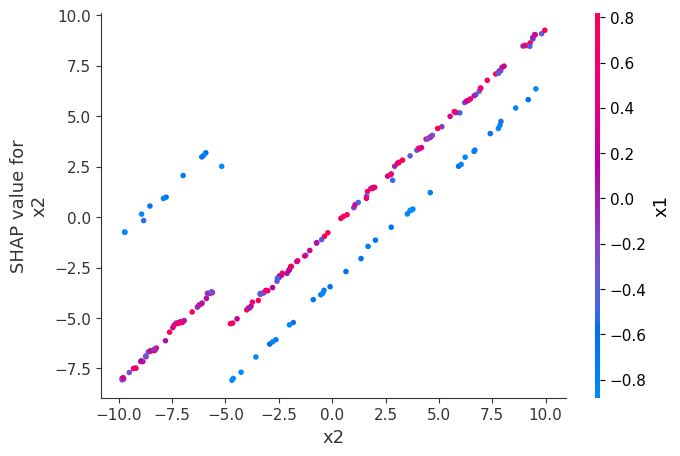

In [482]:
shap_values = explainer.shap_values(X_test)
shap.dependence_plot("x2", shap_values, X_test)

But, Christoph, this is such an artificial example, what does this have to do with real ML applications?

The thing that happened here in the extreme plays out in more complex ways in real applications. Only potentially with more features and the interactions won't be so blunt but might be more smoothly and intricate.

But qualitatively, the same things happen as described above.

The same advice for interpretation of Shapley values remains.